In [11]:
!pip uninstall -y gymnasium

Found existing installation: gymnasium 1.1.1
Uninstalling gymnasium-1.1.1:
  Successfully uninstalled gymnasium-1.1.1


In [1]:
!pip install gymnasium[atari] ale-py

In [2]:
!pip install gym[atari]

  Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.0
    Uninstalling ale-py-0.11.0:
      Successfully uninstalled ale-py-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [3]:
!pip install "gym[atari,accept-rom-license]"

In [4]:
!pip install autorom

In [5]:
!pip install numpy==1.23.5

In [6]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.

I own a license to these Atari 2600 ROMs.
I agree to not distribute these ROMs and wish to proceed: [Y/n]: y
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.11/dist-packages/

In [7]:
import gym
import numpy as np
import cv2
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [8]:
class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, env, shape=(84, 84)):
        super(PreprocessFrame, self).__init__(env)
        self.shape = shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(shape[0], shape[1], 1), dtype=np.float32)

    def observation(self, obs):
        return self.process(obs, self.shape)

    @staticmethod
    def process(frame, shape):
        # Only convert to grayscale if input has 3 channels (RGB)
        if frame.ndim == 3 and frame.shape[2] == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        elif frame.ndim == 2:
            pass  # Already grayscale
        else:
            raise ValueError(f"Unexpected frame shape: {frame.shape}")

        frame = cv2.resize(frame, shape, interpolation=cv2.INTER_AREA)
        return np.expand_dims(frame, axis=-1).astype(np.float32) / 255.0

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        super(FrameStack, self).__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(shp[0], shp[1], shp[2] * k), dtype=np.float32)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Frame is already preprocessed by PreprocessFrame
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        # Do not call self.env.observation again
        self.frames.append(obs)
        return self._get_obs(), reward, terminated, truncated, info

    def _get_obs(self):
        return np.concatenate(list(self.frames), axis=-1)

In [9]:
class DQN_CNN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 1.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)  # ← fix here
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [10]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_shape, n_actions, device):
        self.device = device
        self.n_actions = n_actions
        self.online_net = DQN_CNN(state_shape[0], n_actions).to(device)
        self.target_net = DQN_CNN(state_shape[0], n_actions).to(device)
        self.update_target()

        self.optimizer = optim.Adam(self.online_net.parameters(), lr=1e-4)
        self.replay_buffer = ReplayBuffer(capacity=100_000)

        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_final = 0.05
        self.epsilon_decay = 1_000_000
        self.frame_idx = 0

    def update_target(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def act(self, state):
        self.frame_idx += 1
        epsilon = self.epsilon_final + (self.epsilon_start - self.epsilon_final) * \
                  np.exp(-1. * self.frame_idx / self.epsilon_decay)

        if random.random() < epsilon:
            return random.randrange(self.n_actions)
        else:
            state = torch.tensor(np.array(state), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.online_net(state)
            return q_values.argmax().item()

    def push(self, *args):
        self.replay_buffer.push(*args)

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return None

        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

        state = torch.tensor(state, dtype=torch.float32).permute(0, 3, 1, 2).to(self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32).permute(0, 3, 1, 2).to(self.device)
        action = torch.tensor(action, dtype=torch.int64).unsqueeze(1).to(self.device)
        reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(1).to(self.device)
        done = torch.tensor(done, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values = self.online_net(state).gather(1, action)
        next_q_values = self.target_net(next_state).max(1)[0].detach().unsqueeze(1)
        expected_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = nn.MSELoss()(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
env = PreprocessFrame(env)
env = FrameStack(env, 4)

n_actions = env.action_space.n
state_shape = (4, 84, 84)
agent = DQNAgent(state_shape, n_actions, device)

num_episodes = 1000
target_update_freq = 1000
rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.push(state, action, reward, next_state, done)
        agent.train_step()
        state = next_state
        episode_reward += reward

        if agent.frame_idx % target_update_freq == 0:
            agent.update_target()

    rewards.append(episode_reward)
    print(f"Episode {episode + 1} | Reward: {episode_reward:.2f}")

    if (episode + 1) % 10 == 0:
        torch.save(agent.online_net.state_dict(), f"dqn_model_ep{episode + 1}.pth")

KeyboardInterrupt: 

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ActorCriticNet(nn.Module):
    def __init__(self, input_channels, n_actions):
        super(ActorCriticNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.ReLU()
        )
        self.actor = nn.Linear(512, n_actions)
        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = x / 1.0
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return self.actor(x), self.critic(x)

In [13]:
import torch
import torch.optim as optim
import numpy as np
import random

class ActorCriticAgent:
    def __init__(self, state_shape, n_actions, device):
        self.device = device
        self.n_actions = n_actions
        self.gamma = 0.99

        self.model = ActorCriticNet(state_shape[0], n_actions).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits, _ = self.model(state)
        probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(probs, num_samples=1)
        return action.item()

    def compute_returns(self, rewards, dones, last_value):
        returns = []
        R = last_value
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * (1 - dones[step])
            returns.insert(0, R)
        return returns

    def train(self, states, actions, rewards, dones, next_state):
        states = torch.tensor(np.array(states), dtype=torch.float32).permute(0, 3, 1, 2).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        with torch.no_grad():
            _, next_value = self.model(torch.tensor(np.array(next_state), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(self.device))
            returns = self.compute_returns(rewards.cpu().numpy(), dones.cpu().numpy(), next_value.item())
            returns = torch.tensor(returns, dtype=torch.float32).to(self.device).unsqueeze(1)

        logits, values = self.model(states)
        probs = torch.softmax(logits, dim=-1)
        log_probs = torch.log_softmax(logits, dim=-1)
        action_log_probs = log_probs.gather(1, actions)

        advantages = returns - values

        actor_loss = -(action_log_probs * advantages.detach()).mean()
        critic_loss = advantages.pow(2).mean()
        total_loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

In [14]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = PreprocessFrame(env)
env = FrameStack(env, 4)

n_actions = env.action_space.n
state_shape = (4, 84, 84)
agent = ActorCriticAgent(state_shape, n_actions, device)

num_episodes = 1000
rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    episode_reward = 0

    states, actions, rewards_buf, dones = [], [], [], []

    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Collect transition
        states.append(state)
        actions.append(action)
        rewards_buf.append(reward)
        dones.append(done)

        state = next_state
        episode_reward += reward

    agent.train(states, actions, rewards_buf, dones, next_state)
    rewards.append(episode_reward)

    print(f"Episode {episode + 1} | Reward: {episode_reward:.2f}")

<ipython-input-13-9657866f9fef>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device).unsqueeze(1)


Episode 1 | Reward: -21.00
Episode 2 | Reward: -19.00
Episode 3 | Reward: -20.00
Episode 4 | Reward: -19.00
Episode 5 | Reward: -21.00
Episode 6 | Reward: -20.00
Episode 7 | Reward: -21.00
Episode 8 | Reward: -20.00
Episode 9 | Reward: -21.00
Episode 10 | Reward: -19.00
Episode 11 | Reward: -21.00
Episode 12 | Reward: -20.00
Episode 13 | Reward: -21.00
Episode 14 | Reward: -21.00
Episode 15 | Reward: -19.00
Episode 16 | Reward: -21.00
Episode 17 | Reward: -20.00
Episode 18 | Reward: -21.00
Episode 19 | Reward: -20.00
Episode 20 | Reward: -21.00
Episode 21 | Reward: -21.00
Episode 22 | Reward: -21.00
Episode 23 | Reward: -20.00
Episode 24 | Reward: -19.00
Episode 25 | Reward: -21.00
Episode 26 | Reward: -19.00
Episode 27 | Reward: -20.00
Episode 28 | Reward: -20.00
Episode 29 | Reward: -21.00
Episode 30 | Reward: -19.00
Episode 31 | Reward: -20.00
Episode 32 | Reward: -20.00
Episode 33 | Reward: -20.00
Episode 34 | Reward: -21.00
Episode 35 | Reward: -19.00
Episode 36 | Reward: -20.00
E

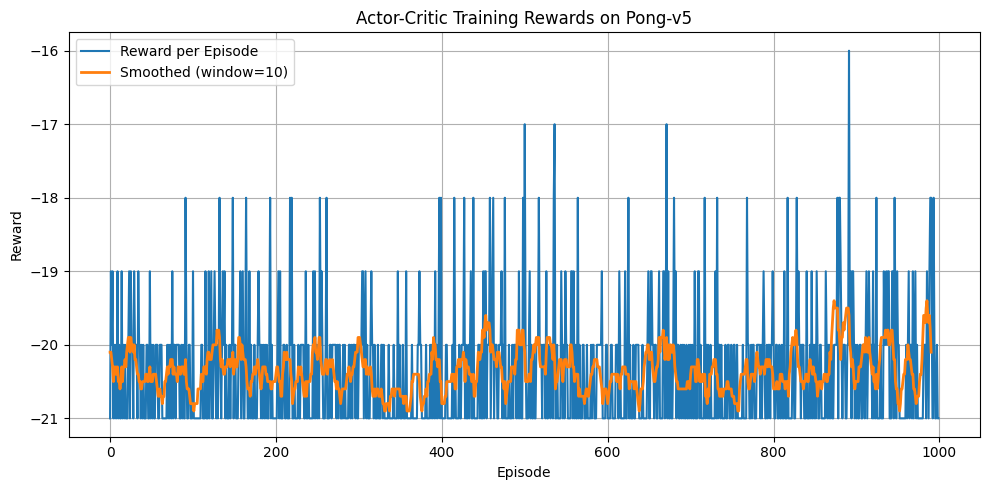

In [15]:
import matplotlib.pyplot as plt

# Optional: moving average to smooth noisy rewards
def moving_average(data, window_size=10):
    return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='Reward per Episode')
if len(rewards) >= 10:
    plt.plot(moving_average(rewards), label='Smoothed (window=10)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Actor-Critic Training Rewards on Pong-v5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ac_rewards_plot.png")
plt.show()

In [16]:
!pip install imageio

In [17]:
import imageio
from IPython.display import Video
import os

video_dir = "ac_play_video"
os.makedirs(video_dir, exist_ok=True)

env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = PreprocessFrame(env)
env = FrameStack(env, 4)

# Load trained weights if needed
# agent.model.load_state_dict(torch.load("ac_model_ep1000.pth"))

frames = []
state, _ = env.reset()
done = False

while not done:
    action = agent.act(state)
    frame = env.env.render()  # Raw RGB frame
    frames.append(frame)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# Save video
video_path = "actor_critic_pong.mp4"
imageio.mimsave(video_path, frames, fps=30)

# Display in notebook
Video(video_path, embed=True)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
